In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, jensenshannon, correlation
from scipy.stats import wasserstein_distance, ecdf
import skgstat as skg
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [2]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF_AI/postproc/'
models=['aifs','graphcast','pangu','sfno','fuxi','tigge']
labels=['aifs','graphcast','pangu','fcnv2','fuxi','ifs']
references=['era']
figpath='/users/mfeldman/figs/scores2/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
colors=[c2,c1,c3,c5,c4,c6]


aifs
graphcast
pangu
sfno
fuxi
tigge


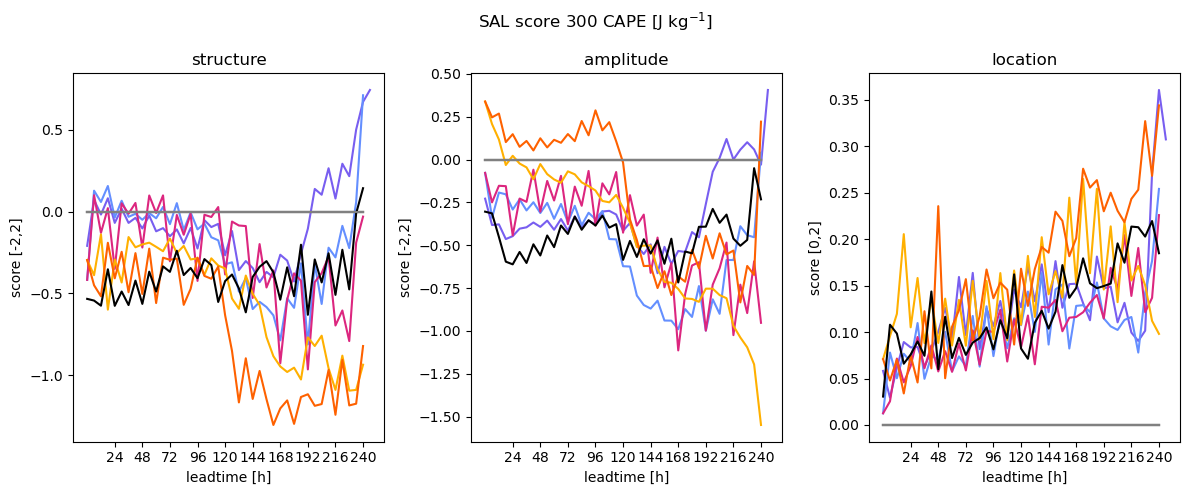

In [4]:
era_ref=xr.open_dataset(datapath+'era5.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
nn=0
mm=0
for mm in range(6)[:1]:
    var=['cape','cin','bs_06','bs_03','bs_01','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]',
         '0-1km shear [m s$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,-100,10,5,5,300][mm]
    l2=[1000,-300,20,10,10,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(len(models)):
        kw='latitude'#['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw2='time'#['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        model=models[nn]
        label=labels[nn]
        color=colors[nn]
        print(model)
        i=8
        if model=='fcnv2_dawn': i=8
        files=sorted(glob(datapath+'*'+model+'*.nc'),reverse=True)
        sal_s=np.zeros([2*len(files)+i,len(files)]); sal_s[:]=np.nan
        sal_a=np.zeros([2*len(files)+i,len(files)]); sal_a[:]=np.nan
        sal_l=np.zeros([2*len(files)+i,len(files)]); sal_l[:]=np.nan

        

        for file in range(3,len(files)-3):
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            if var=='wms':
                capem=model_set.cape.squeeze().values
                wmsm=(capem * 2)**0.5 * model_set.bs_06
                model_set=model_set.assign(wms=lambda model_set: wmsm )
            for tstep in range(len(model_set[kw2])):
                ref=era_ref[var].values[tstep,:,:]
                ref[f1*ref<l1]=0
                mod=model_set[var].values[tstep,:,:]
                mod[f1*mod<l1]=0
                ifile=file-3

                (sal_s[tstep+2*ifile,ifile],sal_a[tstep+2*ifile,ifile],sal_l[tstep+2*ifile,ifile]) = sal(mod, 
                                                                                                   ref)
        
        axes2[0].plot(np.arange(i+2*len(files))*6,np.nanmean(sal_s,axis=1),c=color,label=label)
        axes2[0].plot([0,240],np.zeros(2),c='grey')
        #axes2[0].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_s,axis=1),np.nanmin(sal_s,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('structure')
        axes2[0].set_xlabel('leadtime [h]')
        axes2[0].set_xticks(np.arange(24,258,24))
        axes2[0].set_ylabel('score [-2,2]')
        #axes2[0].legend()
        axes2[1].plot(np.arange(i+2*len(files))*6,np.nanmean(sal_a,axis=1),c=color,label=label)
        axes2[1].plot([0,240],np.zeros(2),c='grey')
        #axes2[1].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_a,axis=1),np.nanmin(sal_a,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('amplitude')
        axes2[1].set_xlabel('leadtime [h]')
        axes2[1].set_xticks(np.arange(24,258,24))
        axes2[1].set_ylabel('score [-2,2]')
        #axes2[1].legend()
        axes2[2].plot(np.arange(i+2*len(files))*6,np.nanmean(sal_l,axis=1),c=color)
        axes2[2].plot([0,240],np.zeros(2),c='grey')
        #axes2[2].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_l,axis=1),np.nanmin(sal_l,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('location')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_xticks(np.arange(24,258,24))
        axes2[2].set_ylabel('score [0,2]')
        fig2.suptitle('SAL score '+str(l1)+' '+tit)


    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_sal_scores.png')


In [14]:
np.arange(i+2*(len(files)-6))*6

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258])

aifs
graphcast
pangu
sfno
fuxi
tigge
aifs
graphcast
pangu
sfno
fuxi
tigge
aifs
graphcast
pangu
sfno
fuxi
tigge
aifs
graphcast
pangu
sfno
fuxi
tigge
aifs
graphcast
pangu
sfno
fuxi
tigge
aifs
graphcast
pangu
sfno
fuxi
tigge


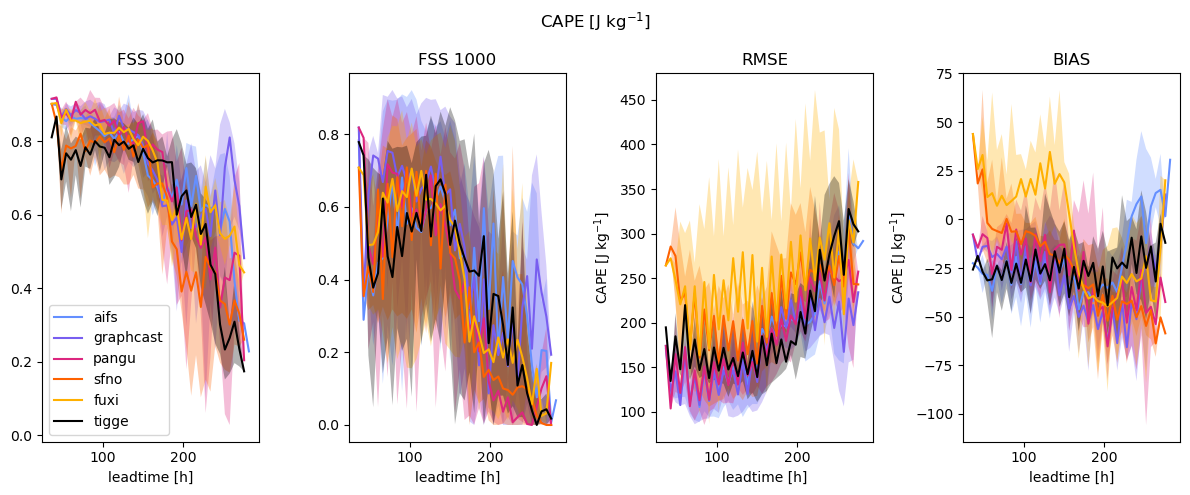

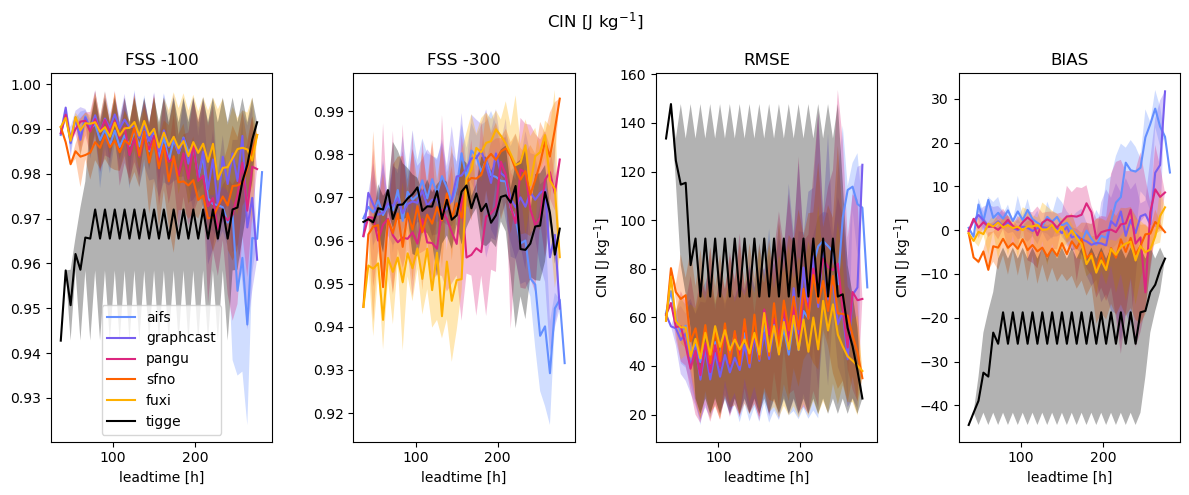

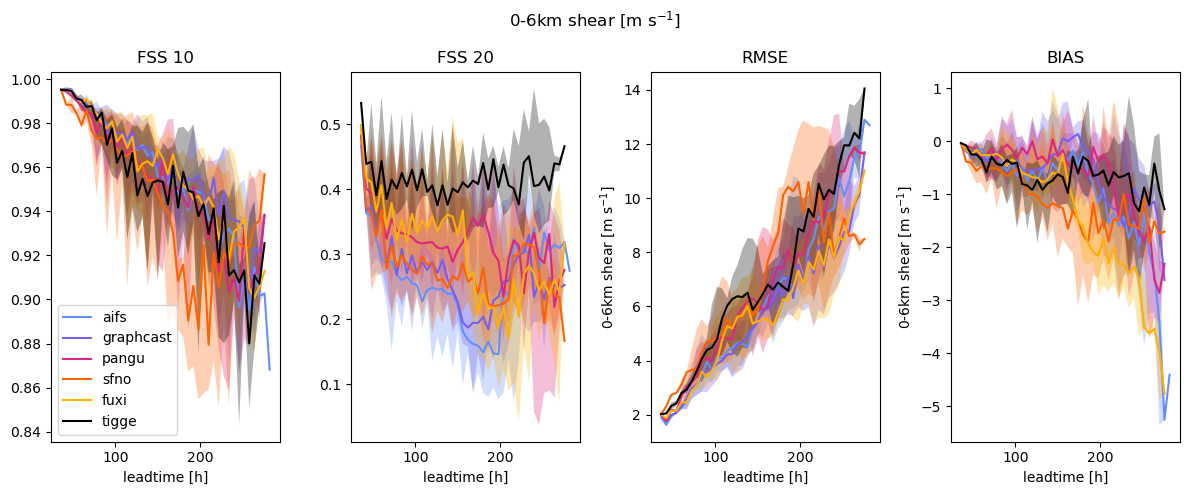

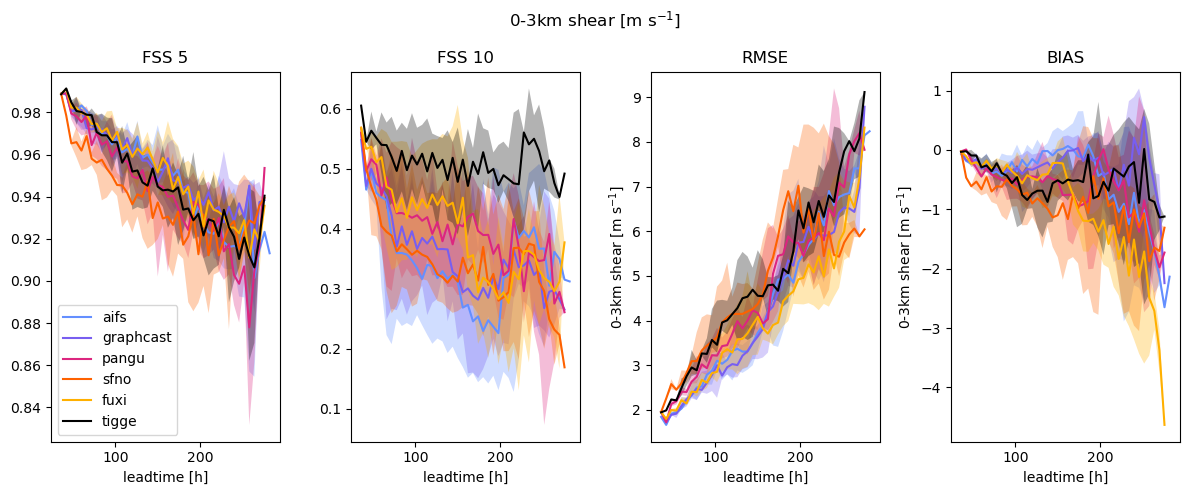

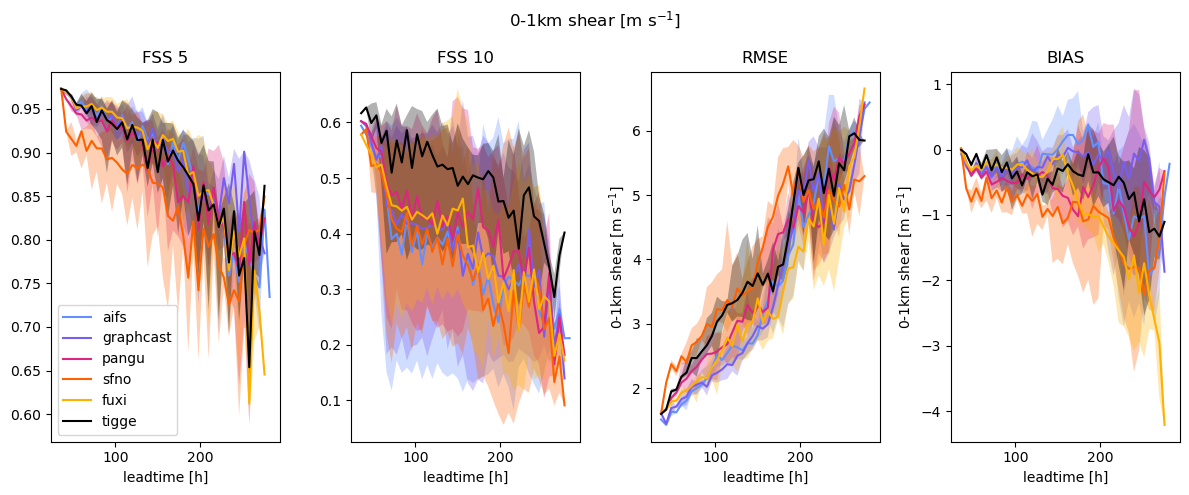

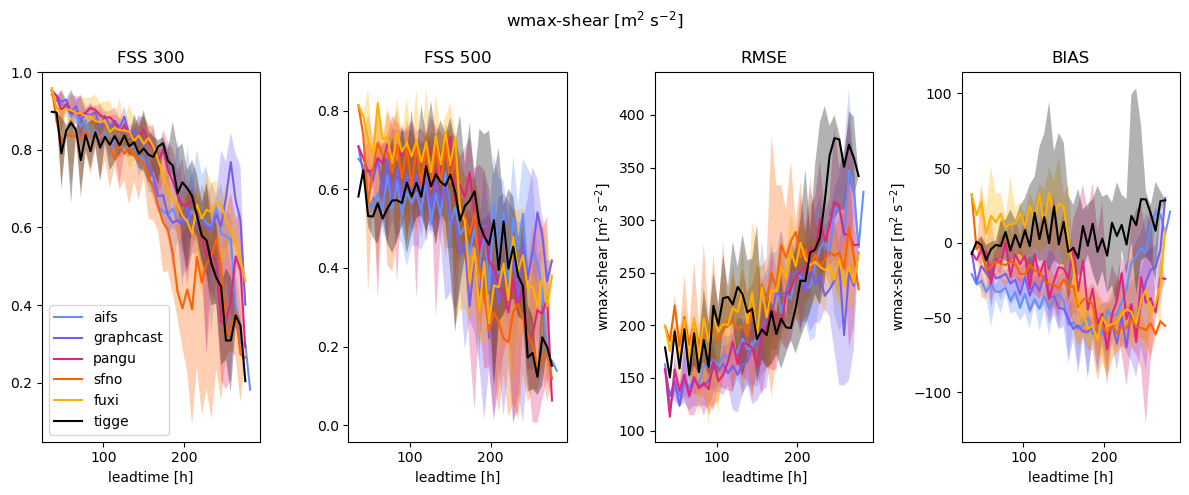

In [3]:
era_ref=xr.open_dataset(datapath+'era5.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
nn=0
mm=0
for mm in range(6)[:]:
    var=['cape','cin','bs_06','bs_03','bs_01','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]',
         '0-1km shear [m s$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,-100,10,5,5,300][mm]
    l2=[1000,-300,20,10,10,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,4,figsize=(12, 5))
    for nn in range(len(models)):
        kw='latitude'#['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw2='time'#['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        model=models[nn]
        print(model)
        i=8
        if model=='fcnv2_dawn': i=8
        files=sorted(glob(datapath+'*'+model+'*.nc'),reverse=True)
        fss_eval_300=np.zeros([2*len(files)+i,len(files)]); fss_eval_300[:]=np.nan
        fss_eval_1000=np.zeros([2*len(files)+i,len(files)]); fss_eval_1000[:]=np.nan
        rmse=np.zeros([2*len(files)+i,len(files)]); rmse[:]=np.nan
        bias=np.zeros([2*len(files)+i,len(files)]); bias[:]=np.nan
        for file in range(3,len(files)-3):
            #print(files[file])
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            if var=='wms':
                capem=model_set.cape.squeeze().values
                wmsm=(capem * 2)**0.5 * model_set.bs_06
                model_set=model_set.assign(wms=lambda model_set: wmsm )
            for tstep in range(len(model_set[kw2])):
                
                fss_eval_300[tstep+2*file,file] = fss(f1*model_set[var].values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l1, scale=4)
                fss_eval_1000[tstep+2*file,file] = fss(f1*model_set.cape.values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l2, scale=4)
                
                rmse[tstep+2*file,file] = np.nanmean((model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])**2)**0.5
                
                bias[tstep+2*file,file] = np.nanmean(model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])
        #print(fss_eval_300[4,:])
                
        color=[c1,c2,c3,c4,c5,c6][nn]

        
        
        # axes[0].plot(range(8+len(files)),fss_eval,c=color)
        # axes[1].plot(range(8+len(files)),rmse,c=color)
        # axes[2].plot(range(8+len(files)),bias,c=color)
        
        axes2[0].plot(np.arange(i+2*len(files))*6,np.nanmedian(fss_eval_300,axis=1),c=color,label=model)
        axes2[0].fill_between(np.arange(i+2*len(files))*6,np.nanmax(fss_eval_300,axis=1),np.nanmin(fss_eval_300,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('FSS '+str(l1))
        axes2[0].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[0].legend()
        axes2[1].plot(np.arange(i+2*len(files))*6,np.nanmedian(fss_eval_1000,axis=1),c=color,label=model)
        axes2[1].fill_between(np.arange(i+2*len(files))*6,np.nanmax(fss_eval_1000,axis=1),np.nanmin(fss_eval_1000,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('FSS '+str(l2))
        axes2[1].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[2].plot(np.arange(i+2*len(files))*6,np.nanmedian(rmse,axis=1),c=color)
        axes2[2].fill_between(np.arange(i+2*len(files))*6,np.nanmax(rmse,axis=1),np.nanmin(rmse,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('RMSE')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel(tit)
        axes2[3].plot(np.arange(i+2*len(files))*6,np.nanmedian(bias,axis=1),c=color)
        axes2[3].fill_between(np.arange(i+2*len(files))*6,np.nanmax(bias,axis=1),np.nanmin(bias,axis=1),facecolor=color,alpha=0.3)
        axes2[3].set_title('BIAS')
        axes2[3].set_xlabel('leadtime [h]')
        axes2[3].set_ylabel(tit)
        fig2.suptitle(tit)
    
        # axes2[0].boxplot(np.transpose(fss_eval),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[1].boxplot(np.transpose(rmse),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[2].boxplot(np.transpose(bias),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
    # fig.show()
    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_scores.png')
            
    # print(fss_eval)
    # print(rmse)
    # print(bias)

In [4]:
model_set.cape

<xarray.DataArray 'cape' (time: 7, latitude: 121, longitude: 201)>
array([[[6.8273926e-01, 0.0000000e+00, 0.0000000e+00, ...,
         1.0912219e+02, 1.0632898e+02, 9.1431763e+01],
        [2.4829102e-01, 6.2011719e-02, 0.0000000e+00, ...,
         1.1284656e+02, 1.1266028e+02, 1.0682556e+02],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         9.6273315e+01, 1.2848853e+02, 1.5387598e+02],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         7.4487305e-01, 2.0483398e+00, 4.8415527e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.3656006e+00, 9.3103027e-01, 1.4897461e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.3345459e+01, 9.5590820e+00, 4.3449707e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.1173096e+00, 4.0966797e+00, 5.7727051e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         8.3176270e+00, 4.1588135e+00, 4.9658203e-01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.6442627e+01, 1.9552612e+01, 1.6014526e+01],
...
        [2.4580444e+01, 7.6968994e+00, 5.4002686e+00, ...,
         3.2897949e+00, 1.7380371e+00, 3.7243652e-01],
        [1.7069702e+01, 2.9794922e+00, 8.6901855e-01, ...,
         4.8415527e+00, 2.7932129e+00, 8.6901855e-01],
        [1.2600586e+01, 2.1414795e+01, 2.3276855e+01, ...,
         2.6690674e+00, 2.2966309e+00, 1.4276123e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         9.6583740e+01, 1.6008313e+02, 2.6386719e+02],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         7.7093140e+01, 8.5969360e+01, 1.3990979e+02],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         6.3933960e+01, 7.9079468e+01, 4.4133057e+01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         5.2761230e+00, 6.3312988e+00, 6.0209961e+00],
        [0.0000000e+00, 0.0000000e+00, 1.2414551e-01, ...,
         1.1793213e+00, 3.6002197e+00, 2.6690674e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 4.3444824e-01]]], dtype=float32)
Coordinates:
  * longitude           (longitude) float32 250.0 250.2 250.5 ... 299.8 300.0
  * latitude            (latitude) float32 20.0 20.25 20.5 ... 49.5 49.75 50.0
    level               int32 ...
  * time                (time) datetime64[ns] 2024-04-02 ... 2024-04-03T12:00:00
    mcape_mcin_lcl_lfc  <U4 ...
Attributes:
    units:      J kg**-1
    long_name:  Convective available potential energy